In [15]:
from glob import glob
import os
from pathlib import Path
import shutil
import urllib.request as request
from contextlib import closing

import matplotlib.pyplot as plt
import pygrib
import xarray as xr
import numpy as np
import cartopy.feature as cfeature
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
from datetime import datetime
from dateutil import tz

In [16]:
grib_dir = Path('.') / 'data'
graphics_dir = Path('.') / '..' / '..' / 'graphics' / 'models' / 'href'

In [26]:
# Download files

date = 20210627
run = '06'
fhr = '36'
left_lon = 360-90
right_lon = 360-77
top_lat = 36
bottom_lat = 24

nomads_url = ('https://nomads.ncep.noaa.gov/cgi-bin/filter_hrefconus.pl?'
              f'file=href.t{run}z.conus.prob.f{fhr}.grib2'
              '&all_lev=on&var_MAXREF=on&subregion='
              f'&leftlon={left_lon}&rightlon={right_lon}&toplat={top_lat}&bottomlat={bottom_lat}&'
              f'dir=/href.{date}/ensprod')

def download_gribfilter(file_url: str):
    with closing(request.urlopen(file_url)) as r:
        with open(f'{grib_dir}/href/href.t{run}z.conus.prob.maxrefl.f{fhr}.grib2', 'wb') as f:
            shutil.copyfileobj(r, f)
        
download_gribfilter(nomads_url)

In [27]:
#%%capture
# Read in files and acquire data needed for plotting
ds = pygrib.open(f'{grib_dir}/href/href.t{run}z.conus.prob.maxrefl.f{fhr}.grib2',)

# Reset the grib messages to 0 so you're at beginning of the file
ds.seek(0)

# Get grib message
# For reference, here are the corresponding grib messages with reflectivity exceedance
# 1 = 40dbZ; 2 = 50dbZ,
ds = ds[2]

# Extract lats, lons, and data values
lats, lons = ds.latlons()
href_values = ds.values

def convert_datetime(pygrib_time: str) -> str:
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New York')
    utc_time = datetime.strptime(pygrib_time, '%Y%m%d %H%M').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

# Get the date and time of the forecast
dt = str(ds.validityDate) + ' ' + str(ds.validityTime)
VALID_TIME = convert_datetime(dt)

In [28]:
def get_gridpoint_value(lat_of_interest: float, lon_of_interest: float) -> int:
    '''
    Calculate the closest gridpoint value to a given latitude
    and longitude.
    '''
    abs_lat = np.abs(lats - lat_of_interest)
    abs_lon = np.abs(lons - lon_of_interest)
    
    overlap_latlon = np.maximum(abs_lon, abs_lat)
    latlon_idx = np.argmin(overlap_latlon)
    
    href_1d = href_values.flatten()
    
    return href_1d[latlon_idx]


kgnv_prob = np.round(get_gridpoint_value(29.65, -82.32)).astype(int)
kpns_prob = np.round(get_gridpoint_value(30.4213, -87.2169)).astype(int)
ktlh_prob = np.round(get_gridpoint_value(30.4383, -84.2807)).astype(int)
kjax_prob = np.round(get_gridpoint_value(30.3322, -81.6557)).astype(int)
ktpa_prob = np.round(get_gridpoint_value(27.9506, -82.4572)).astype(int)
kmco_prob = np.round(get_gridpoint_value(28.5383, -81.3792)).astype(int)
kfmy_prob = np.round(get_gridpoint_value(26.6406, -81.8723)).astype(int)
kmia_prob = np.round(get_gridpoint_value(25.7617, -80.1918)).astype(int)

# SC cities
kcae_prob = np.round(get_gridpoint_value(34.0007, -81.0348)).astype(int)
kmyr_prob = np.round(get_gridpoint_value(33.6891, -78.8867)).astype(int)
kchs_prob = np.round(get_gridpoint_value(32.7765, -79.9311)).astype(int)
kgsp_prob = np.round(get_gridpoint_value(34.8526, -82.3940)).astype(int)
kuza_prob = np.round(get_gridpoint_value(34.9249, -81.0251)).astype(int)

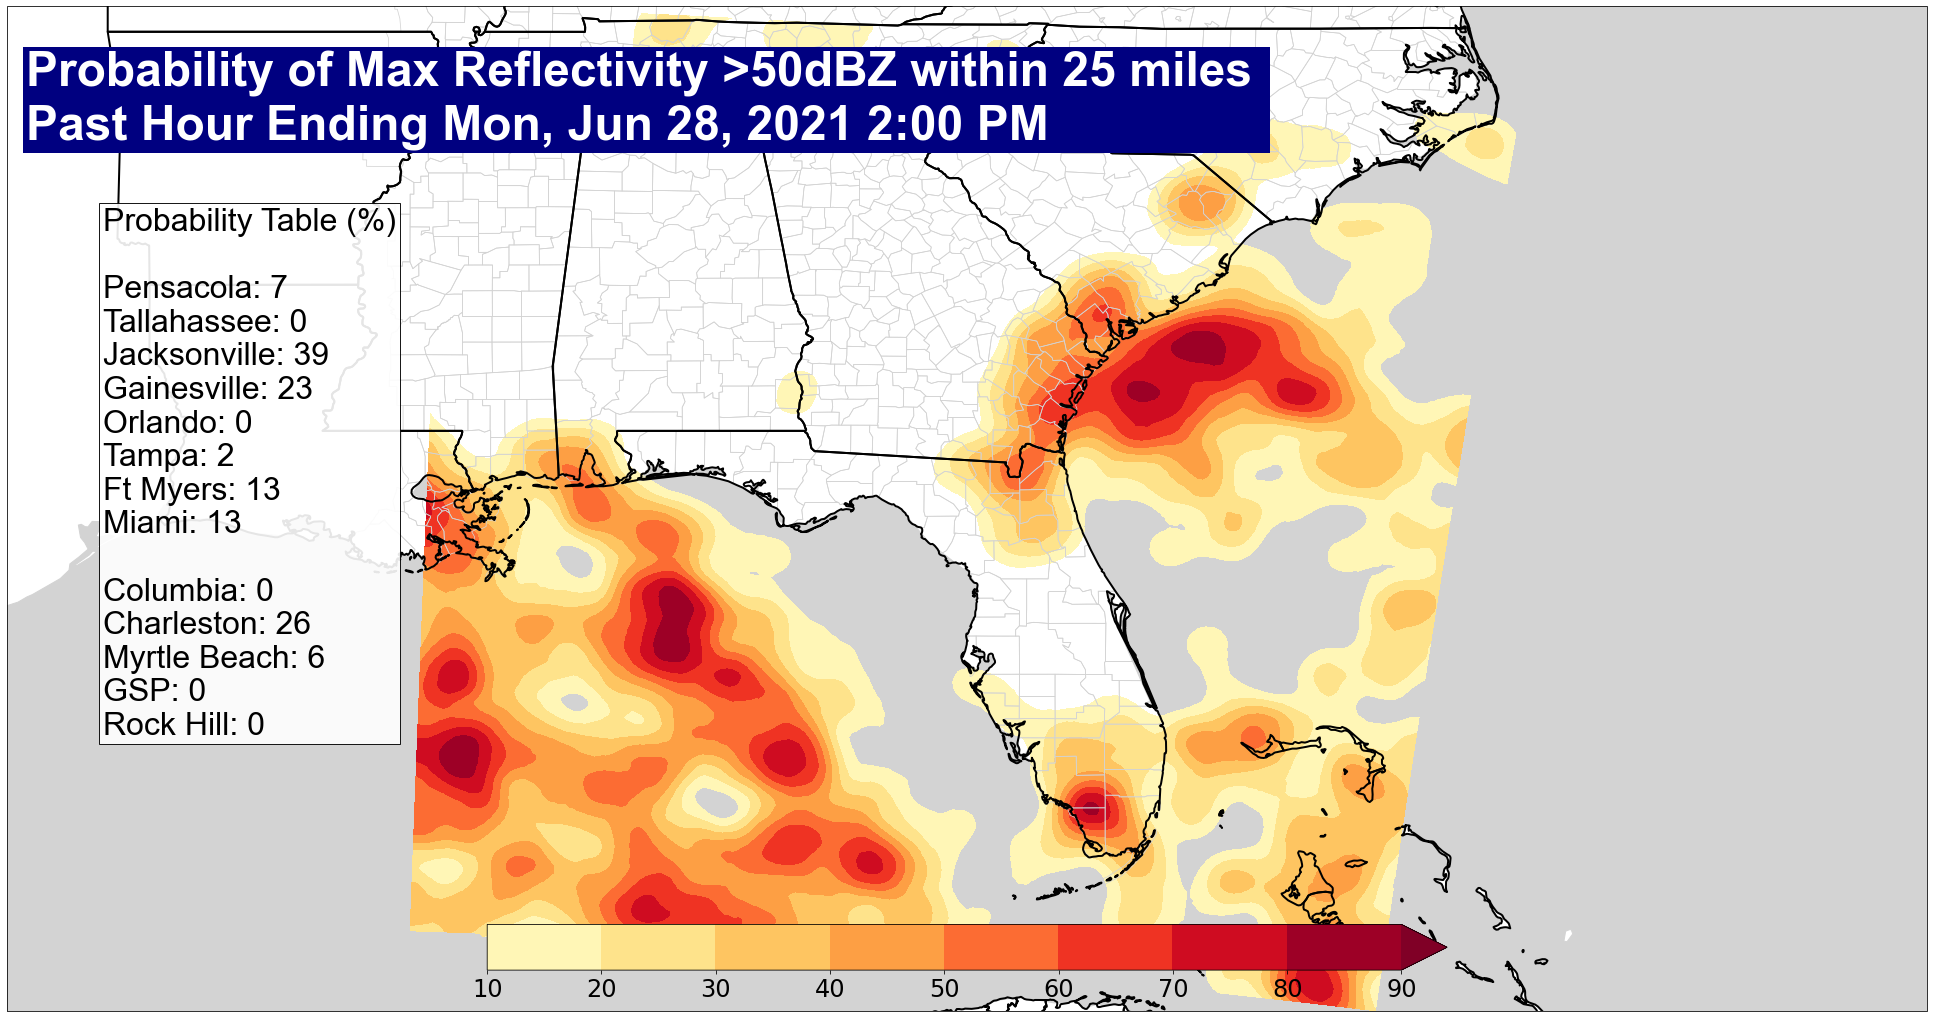

In [29]:
fig = plt.figure(figsize=(1920/72, 1080/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

ax.add_feature(cfeature.OCEAN.with_scale('50m'), color='lightgray')
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=2.0)
ax.set_adjustable('datalim')
#ax.set_extent([-82, -79, 31, 36])
#ax.set_extent([-87, -80, 23.5, 32])

data_range = [num for num in np.arange(10, 100, 10)]
contour = ax.contourf(lons, lats, href_values, data_range, cmap=plt.cm.YlOrRd, 
                      extend='max', transform=ccrs.PlateCarree())

cbar = plt.colorbar(contour, orientation='horizontal', pad=-0.08, shrink=0.5,)
cbar.ax.tick_params(labelsize='24')

# Add probability table
probs = ('Probability Table (%)\n\n'
         f'Pensacola: {kpns_prob}\n'
         f'Tallahassee: {ktlh_prob}\n'
         f'Jacksonville: {kjax_prob}\n'
         f'Gainesville: {kgnv_prob}\n'
         f'Orlando: {kmco_prob}\n'
         f'Tampa: {ktpa_prob}\n'
         f'Ft Myers: {kfmy_prob}\n'
         f'Miami: {kmia_prob}\n\n'
         f'Columbia: {kcae_prob}\n'
         f'Charleston: {kchs_prob}\n'
         f'Myrtle Beach: {kmyr_prob}\n'
         f'GSP: {kgsp_prob}\n'
         f'Rock Hill: {kuza_prob}')

ax.text(0.05, 0.80, s=probs, fontsize=32, bbox=dict(facecolor='white', alpha=0.9), 
         transform=ax.transAxes, zorder=4, verticalalignment='top', fontname='Arial')

# Make the axis title
ax.set_title(f'Probability of Max Reflectivity >50dBZ within 25 miles \nPast Hour Ending {VALID_TIME}', loc='left', 
             ha='left', va='top', fontsize=48, fontname='Arial',
             color='white', fontweight='bold', y=0.95, x=0.01,
             bbox=dict(facecolor='navy', alpha=1.0, edgecolor='none'))

# Save and show figure
plt.savefig(f'{graphics_dir}/mxrefd_{fhr}.png', dpi=72)
plt.show()